In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from os.path import join
import ipywidgets as widgets
from IPython.display import display
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import pickle
from torchsampler import ImbalancedDatasetSampler
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#import torch
from matplotlib import animation
import torch.nn.functional as F
from torch import nn, cuda
from torch.autograd import Variable

**Observaciones**

### Definiciones de Clases, Variables, Datasets

In [3]:
# original

class LightCurveRRL_Dataset(Dataset):
    def __init__(self, df_metadata, folder_name, transform=None):        
        self.data = list()
        self.name = df_metadata["ID_VVV"]
        self.period = df_metadata["OGLE_period"]
        self.label = torch.from_numpy(df_metadata["label"].values)
        self.transform = transform
        column_names_lc = ["mjd", "mag", "err"]
        column_names_fill = ["mjd", "mag", "err", "phase", "mask"]
        self.folder = folder_name
        #self.classes = ["T2C", "ECL"]
        df_zeros = pd.DataFrame(np.zeros((1, 5)),columns=column_names_fill)
                
        for i in range(len(df_metadata)):
            rrl_data = pd.read_csv(join(data_path, self.folder, self.name[i]+'.dat'), 
                                  header=None, delim_whitespace=True, comment='#', names=column_names_lc)
            #rrl_data.sort_values(by="mjd", inplace=True)
            rrl_data["phase"] = np.mod(rrl_data["mjd"], self.period[i])/self.period[i]
            #normalize
            mag_std = rrl_data["mag"].std()
            rrl_data["mjd"] = rrl_data["mjd"]-rrl_data["mjd"].min()
            rrl_data["mag"] = (rrl_data["mag"]-rrl_data["mag"].mean())/mag_std
            rrl_data["err"] = rrl_data["err"]/mag_std
            rrl_data.sort_values(by="phase", inplace=True)
            # ajustar todas a largo 335, rellenando con 0s las que sean mas pequeñas,
            # asignando un label '1' si es dato real y '0' si es dato rellenado.
            if len(rrl_data) == 335:
                rrl_data["mask"] = 1
            else:
                while len(rrl_data) < 335:
                    #RELLENAR con 0s;
                    rrl_data = rrl_data.append(df_zeros, ignore_index=True,sort=False)
            rrl_data = rrl_data.fillna(1)
            rrl_data = rrl_data[["phase","mag","err","mjd","mask"]]
            self.data.append(torch.from_numpy(rrl_data.values.astype('float32')))
            
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.label[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def plot(self, idx, ax):
        assert len(ax)==2, "Needs two subaxis"
        ax[0].cla()  
        ax[0].errorbar(self.data[idx][:, 0], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[0].invert_yaxis()
        ax[1].cla()
        ax[1].errorbar(self.data[idx][:, 3], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[1].invert_yaxis()
        ax[0].set_title("%d %s %0.4f" %(idx, self.name[idx],self.period[idx]))

    def __len__(self):
        return len(self.data)

In [ ]:
# Magnitude Interpolation
#import torch
from torch.utils.data import Dataset

class LightCurveRRL_Dataset(Dataset):
    def __init__(self, df_metadata, folder_name, transform=None):        
        self.data = list()
        self.name = df_metadata["ID_VVV"]
        self.period = df_metadata["OGLE_period"]
        self.label = torch.from_numpy(df_metadata["label"].values)
        self.transform = transform
        column_names_lc = ["mjd", "mag", "err"]
        #column_names_fill = ["mjd", "mag", "err", "phase", "real"]
        self.folder = folder_name
        self.mag_inter = torch.empty(100)
        self.label = torch.empty(1)
        #self.classes = ["T2C", "ECL"]
        #df_zeros = pd.DataFrame(np.zeros((1, 5)),columns=column_names_fill)
                
        for i in range(len(df_metadata)):
            rrl_data = pd.read_csv(join(data_path, self.folder, self.name[i]+'.dat'), 
                                  header=None, delim_whitespace=True, comment='#', names=column_names_lc)
            rrl_data["phase"] = np.mod(rrl_data["mjd"], self.period[i])/self.period[i]
            #normalize
            mag_std = rrl_data["mag"].std()
            rrl_data["mjd"] = rrl_data["mjd"]-rrl_data["mjd"].min()
            rrl_data["mag"] = (rrl_data["mag"]-rrl_data["mag"].mean())/mag_std
            rrl_data["err"] = rrl_data["err"]/mag_std
            # Interpolacion
            # ventaneo Gaussiano
            window = lambda phi_point : np.exp(-0.5*(phi_point-rrl_data["phase"])**2/0.03**2)
            # espaciado regular de 100 pts entre 0 y 1
            phi_interp = np.linspace(0, 1, num=100)
            # cálculo de la interpolacion (prediccion) de la magnitud "basado en la cercania entre los puntos"
            rrl_data["mag"] = np.array([np.sum(window(phi_val)*rrl_data["mag"])/np.sum(window(phi_val)) for phi_val in phi_interp])
            rrl_data.sort_values(by="phase", inplace=True)
            # orden cols: ['mjd','mag','err','phase']
            self.data.append(torch.from_numpy(rrl_data.values.astype('float32')))
            
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.label[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    #def plot(self, idx, ax):
    #    assert len(ax)==2, "Needs two subaxis"
    #    ax[0].cla()  
    #    ax[0].errorbar(self.data[idx][:, 0], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
    #    ax[0].invert_yaxis()
    #    ax[1].cla()
    #    ax[1].errorbar(self.data[idx][:, 3], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
    #    ax[1].invert_yaxis()
    #    ax[0].set_title("%d %s %0.4f" %(idx, self.name[idx],self.period[idx]))

    def __len__(self):
        return len(self.data)


In [ ]:
class LightCurveDataset_interpol(Dataset):
    def __init__(self,old_dataset):
        self.new_data = list()
        self.phase = torch.empty(335)
        self.mag = torch.empty(335)
        #self.mask = torch.empty(335)
        self.label = torch.empty(1)
        # espaciado regular de 100 pts entre 0 y 1
        phi_interp = np.linspace(0, 1, num=100)
        for i in old_dataset:
            #asd = i['data'].transpose(0,1)
            phase_data = i['data'][:,3]
            self.label = i['label']
            #print(self.label)
            idx = phase_data.argsort()
            self.phase = i['data'][:,3][idx]
            self.mag = i['data'][:,1][idx]
            print(self.mag)
            #self.mask = i['data'][:,4][idx]
            #datos = torch.stack((self.phase,self.mag,self.mask),0)
            # Interpolacion
            # ventaneo Gaussiano
            window = lambda phi_point : np.exp(-0.5*(self.phase-phi_point)**2/0.03**2)
            # cálculo de la interpolacion (prediccion) de la magnitud "basado en la cercania entre los puntos"
            mag_interp = np.array([np.sum(window(phi_val)*self.mag)/np.sum(window(phi_val)) for phi_val in phi_interp])
            datos=torch.from_numpy(mag_interp)
            self.new_data.append({'data':datos,'label':self.label})
    
    def __getitem__(self,i):
        sample = {'data': self.new_data[i]['data'], 'label': self.new_data[i]['label']}
        return sample
    
    def __len__(self):
        return len(self.new_data)
            

In [4]:
with open('PhaseSorted_NotInterp_ecl_c.pkl', 'rb') as handle:
    vvv_ecl_c = pickle.load(handle)
#label 0

In [5]:
with open('PhaseSorted_NotInterp_ecl_nc.pkl', 'rb') as handle:
    vvv_ecl_nc = pickle.load(handle)
#label 1

In [6]:
with open('PhaseSorted_NotInterp_ell.pkl', 'rb') as handle:
    vvv_ell = pickle.load(handle)
#label 2

In [7]:
with open('PhaseSorted_NotInterp_rrab.pkl', 'rb') as handle:
    vvv_rrab = pickle.load(handle)
#label 3

In [8]:
with open('PhaseSorted_NotInterp_rrc.pkl', 'rb') as handle:
    vvv_rrc = pickle.load(handle)
#label 4

In [9]:
VVV_b = [vvv_ecl_c,vvv_ecl_nc,vvv_ell,vvv_rrab,vvv_rrc]
VVV_len = [len(i) for i in VVV_b]
class_names = ['ECL_C','ECL_NC','ELL','RRAB','RRC']
#class_names = ['RRAB','RRC','ECL_C','ECL_NC','ELL']

In [10]:
def count_classes(datos):
    assert int(datos[0]['label'].item())==0
    classes=[[0,0],[1,0],[2,0],[3,0],[4,0]]
    for data in datos:
        label = int(data['label'].item())
        #print(label)
        if label == 0:
            classes[0][1]+=1
        elif label == 1:
            classes[1][1]+=1
        elif label == 2:
            classes[2][1]+=1
        elif label == 3:
            classes[3][1]+=1
        elif label == 4:
            classes[4][1]+=1
    return classes
            


#### Dataset

In [11]:
VVV = torch.utils.data.ConcatDataset([vvv_ecl_c, vvv_ecl_nc, vvv_ell,vvv_rrab, vvv_rrc])
#VVV = torch.utils.data.ConcatDataset([vvv_ecl_c, vvv_rrab])

In [ ]:
#phase = VVV[420]['data'][:,0]
#mag = VVV[420]['data'][:,1]
#err = VVV[420]['data'][:,2]
#mask = VVV[420]['data'][:,4]

In [ ]:
VVV[420]['data'][:,4]

In [ ]:
tipos=count_classes(VVV)
tipos

In [ ]:
#VVV200_len = [i[1] for i in tipos]
VVV_len

In [ ]:
cantidad_menor

In [ ]:
for i,a in enumerate(VVV200_len):
    np.random.permutation(np.arange(5))[:3]

In [ ]:
VVV_len

### Transformar, filtrar, conocer, jugar con datos
- Ordenar por Phase: idx = argsort('phase')
- Crear mag_sort segun idx calculado: mag_sort[idx]
- Ordenar máscara acorde a distribucion generada anteriormente: mask_sort[idx]

> lo anterior hará que el tiempo ya no sea relevante y le dará información mas "directa" a la red del comportamiento de la estrella a estudiar.
Además pasaremos de tener 5 columnas (canales para la red) a trabajar con sólo 3: Phase, Mag y Mask.
Posteriormente, segun como sea el entrenamiento/aprendizaje del modelo, se incluirá la columna de Error.

In [ ]:
best_interpoladas = LightCurveDataset_interpol(best_ecl_rrab)
print(best_interpoladas)
        

In [ ]:
VVV_pha = LightCurveDataset_interpol(VVV)
# VVV_pha[n° curva de luz][data o label][pha, mag, mask]

In [ ]:
VVV_pha[0]['data'][0]

In [ ]:
len(VVV),len(VVV_pha)

Observamos la desigualdad de clases

In [ ]:
for i,a in enumerate(VVV_b):
    print("% de",class_names[i],"en VVV:",len(a)/len(VVV)*100)
    #print("peso inverso: ",1-len(a)/len(VVV))

In [ ]:
plt.figure()
plt.bar(range(5),VVV_len, tick_label=class_names)

In [ ]:
minimo = min([sum(i['data'][:,4]==1) for i in VVV])
print(minimo)
# 51

In [13]:
# pts100 son las curvas de luz con 100 o más puntos/entradas 'validas' (mascara mas larga = mayor # de 1s)
pts100 = list()
for i in VVV:
    mask=i['data'][:,4]
    if sum(mask)>=100:
        pts100.append(i)
print(len(pts100))

9797


In [85]:
display(pts100.__len__(),count_classes(pts100))

9797

[[0, 2740], [1, 4196], [2, 158], [3, 2616], [4, 87]]

In [87]:
best_0=list()
for i in pts100:
    if i['label'].item()==0:
        best_0.append(i)

print(len(best_0))

best_1=list()
for i in pts100:
    if i['label'].item()==1:
        best_1.append(i)

print(len(best_1))

best_2=list()
for i in pts100:
    if i['label'].item()==2:
        best_2.append(i)

print(len(best_2))

best_3=list()
for i in pts100:
    if i['label'].item()==3:
        best_3.append(i)

print(len(best_3))

best_4=list()
for i in pts100:
    if i['label'].item()==4:
        best_4.append(i)

print(len(best_4))

2740
4196
158
2616
87


In [15]:
classes = ('ECL_Contact', 'ECL_No-Contact', 'Ellipsoid','RRL_AB', 'RRL_C')
#besties = list()
#best_of_best=list()
#best2ofthem=list()

In [ ]:
pts100[420]['data'][:,4]

In [89]:
np.random.randint?

In [93]:
def plotea(datos, k, ax,classes):
    #assert len(ax)==1, "Needs one subaxis"
    n = sum(datos[k]['data'][:,4] == 1)
    #n = sum([1 for i in datos[k]['data'][:,4]==1 if i==True])
    #print(n)
    l = datos[k]['label'].item()
    pha=datos[k]['data'][:n,0]
    mag=datos[k]['data'][:n,1]
    err=datos[k]['data'][:n,2]
    ax.cla()
    ax.errorbar(pha, mag, err, fmt='b.')
    ax.invert_yaxis()
    ax.set_title("estrella tipo %s, pts=%d, k=%d" %(classes[l],n,k))

def plotea2(datos, k1,k2, ax,classes):
    assert len(ax)==2, "Needs two subaxis"
    n1 = sum(datos[k1]['data'][:,4] == 1)
    n2 = sum(datos[k2]['data'][:,4] == 1)
    l1 = datos[k1]['label'].item()
    pha1=datos[k1]['data'][:n1,0]
    mag1=datos[k1]['data'][:n1,1]
    err1=datos[k1]['data'][:n1,2]
    l2 = datos[k2]['label'].item()
    pha2=datos[k2]['data'][:n2,0]
    mag2=datos[k2]['data'][:n2,1]
    err2=datos[k2]['data'][:n2,2]
    [ax_.cla() for ax_ in ax]
    ax[0].errorbar(pha1, mag1, err1, fmt='b.')
    ax[0].invert_yaxis()
    ax[0].set_title("estrella tipo %s, pts=%d, k=%d" %(classes[l1],n1,k1))
    ax[1].errorbar(pha2, mag2, err2, fmt='r.')
    ax[1].invert_yaxis()
    ax[1].set_title("estrella tipo %s, pts=%d, k=%d" %(classes[l2],n2,k2))

<IPython.core.display.Javascript object>


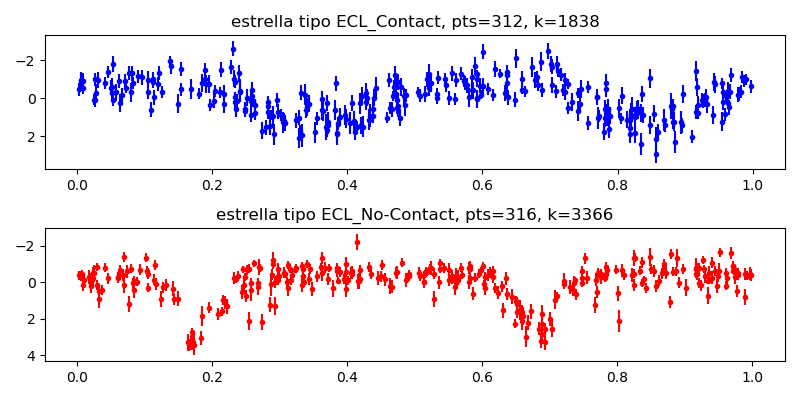

In [97]:
num1= 2740
num2= 4196
k1 = np.random.randint(num1)
k2 = np.random.randint(num1,num1+num2)
fig, ax = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)

plotea2(pts100,k1,k2, ax,classes)
#plotea(VVV_pha,k, ax,classes)
b1 = widgets.Button(description="Otra")
b2 = widgets.Button(description="Save this")
display(widgets.HBox([b1,b2]))

def on_button_clicked(b):
    global k
    if b.description == "Save this":
        print("not implemented.")
        #best_of_best.append(best_4[k])
        #print("guardada, k=",k,count_classes(best_of_best))
    else:
        k1 = np.random.randint(num1)
        k2 = np.random.randint(num1,num1+num2)
        #print(k)
        plotea2(pts100,k1,k2, ax,classes)
        #plotea(VVV_pha,k, ax,classes)

    
b1.on_click(on_button_clicked)
b2.on_click(on_button_clicked)

#classes = ('ECL_Contact', 'ECL_No-Contact', 'Ellipsoid','RRL_AB', 'RRL_C')

In [96]:
best_rrab,best_ecl_c = list(),list()
for i in best_of_best:
    if i['label']==0:
        best_ecl_c.append(i)
    elif i['label']==3:
        best_rrab.append(i)
print(len(best_rrab),len(best_ecl_c))
        

NameError: name 'best_of_best' is not defined

In [ ]:
best_ecl_rrab = np.concatenate((best_ecl_c,best_rrab),axis=0)
best_ecl_rrab[10]['label']

In [ ]:
# INTERPOLAR
def interpolar_LC(phi,mag):
    # ventaneo Gaussiano
    window = lambda phi_point : np.exp(-0.5*(phi_point-phi)**2/0.03**2)

    # espaciado regular de 100 pts entre 0 y 1
    phi_interp = np.linspace(0, 1, num=100)

    # cálculo de la interpolacion (prediccion) de la magnitud "basado en la cercania entre los puntos"
    mag_interp = np.array([np.sum(window(phi_val)*mag)/np.sum(window(phi_val)) for phi_val in phi_interp])
    
    # PLOT
    #fig,ax=plt.subplots()
    #ax.invert_yaxis()
    #ax.scatter(phi, mag)
    #ax.plot(phi_interp, mag_interp, lw=2, c='r')
    #plt.show()
    #print("plot")
    return mag_interp

In [ ]:
with open('best50_10each_notInterpol.pkl', 'wb') as handle:
    pickle.dump(best_of_best, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('ok')

In [ ]:
with open('best_10ecl_10rrab_10each_notInterpol.pkl', 'wb') as handle:
    pickle.dump(best_ecl_rrab, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('ok')

In [ ]:
display(count_classes(best_of_best))

- para el TEST_set:
    - sacar las 200 primeras LC de cada clase (0,1,2,3,4)
    - 200 0
    - 200 1
    - 200 3
    - 200 2
    - 200 4
- para el TRAIN_set:
    - todas las restantes (66103(?)

In [ ]:
test_set_indices = list()

In [ ]:
c1,c2,c3,c4,c5= 0,0,0,0,0
for i in range(len(VVV)):
    if c1<250:
        if VVV[i].__getitem__('label').item()== 0:
            test_set_indices.append(i)
            c1+=1
    elif c2<250:
        if VVV[i].__getitem__('label').item()== 1:
            test_set_indices.append(i)
            c2+=1
    elif c3<250:
        if VVV[i].__getitem__('label').item()== 2:
            test_set_indices.append(i)
            c3+=1
    elif c4<250:
        if VVV[i].__getitem__('label').item()== 3:
            test_set_indices.append(i)
            c4+=1
    elif c5<250:
        if VVV[i].__getitem__('label').item()== 4:
            test_set_indices.append(i)
            c5+=1
display(len(test_set_indices))    

In [ ]:
c1,c2,c3,c4,c5= 0,0,0,0,0
for i in range(len(VVV_pha)):
    if c1<200:
        if VVV_pha[i].__getitem__('label').item()== 0:
            test_set_indices.append(i)
            c1+=1
    elif c2<200:
        if VVV_pha[i].__getitem__('label').item()== 1:
            test_set_indices.append(i)
            c2+=1
    elif c3<200:
        if VVV_pha[i].__getitem__('label').item()== 2:
            test_set_indices.append(i)
            c3+=1
    elif c4<200:
        if VVV_pha[i].__getitem__('label').item()== 3:
            test_set_indices.append(i)
            c4+=1
    elif c5<200:
        if VVV_pha[i].__getitem__('label').item()== 4:
            test_set_indices.append(i)
            c5+=1

display(len(test_set_indices))    

In [ ]:
targets = [i['label'].item() for i in VVV]
print(targets)

In [16]:
#print(len(pts100))
tipos=count_classes(pts100)
VVV100_len = [i[1] for i in tipos]
for i,a in enumerate(VVV100_len):
    print("cantidad y % de tipo",classes[i],":",a,"->",100*a/VVV.__len__())

cantidad y % de tipo ECL_Contact : 2740 -> 4.083274965351773
cantidad y % de tipo ECL_No-Contact : 4196 -> 6.253073633071547
cantidad y % de tipo Ellipsoid : 158 -> 0.23545892135970076
cantidad y % de tipo RRL_AB : 2616 -> 3.898484419474539
cantidad y % de tipo RRL_C : 87 -> 0.12965143138160737


In [17]:
indice_menor = 5
cantidad_menor100 = min(VVV100_len)
for i,a in enumerate(VVV100_len):
    if a == cantidad_menor100:
        indice_menor=i
print(indice_menor,cantidad_menor100,cantidad_menor100*5)

4 87 435


In [159]:
tipos

[[0, 17882], [1, 26880], [2, 789], [3, 21123], [4, 429]]

In [77]:
VVV_len

[17882, 26880, 789, 21123, 429]

In [155]:
indice_menor = 5
cantidad_menor = min(VVV_len)
for i,a in enumerate(VVV_len):
    if a == cantidad_menor:
        indice_menor=i
print(indice_menor,cantidad_menor, cantidad_menor*5)

4 429 2145


Generar Sampleo Random Manual Equitativo (EMRS)

In [71]:
VVV_toy = list()
ant=0
for i,a in enumerate(VVV_len):
    if i==2:
        randind = np.random.permutation(np.arange(a))[:789]+ant
    elif i==3:
        randind = np.random.permutation(np.arange(a))[:429*3]+ant
    elif i==4:
        randind = np.random.permutation(np.arange(a))[:429]+ant
    else:
        randind = np.random.permutation(np.arange(a))[:429*4]+ant
    VVV_toy.append(randind)
    ant=ant+a
VVV_sameRandInd= np.concatenate(VVV_toy)
display(VVV_sameRandInd, len(VVV_sameRandInd))

array([  847,   899,   137, ..., 67066, 66901, 66978])

5937

In [19]:
VVV100_toy = list()
ant=0
for i,a in enumerate(VVV100_len):
    randind = np.random.permutation(np.arange(a))[:cantidad_menor100]+ant
    VVV100_toy.append(randind)
    ant=ant+a
VVV100_sameRandInd= np.concatenate(VVV100_toy)
VVV100_sameRandInd

array([1012, 1322,  738, 1864, 1555, 2231,  873, 2621, 2207, 1117,  971,
       1029, 1957, 2043, 2063,  275, 1746, 1260,  142, 1609, 2604,  303,
        522,   62, 2287,  563, 2449, 1731,  782, 2477, 2723, 1823,  797,
       1763, 2135, 2366, 1706,  435, 1917, 2453,  948, 1502, 1452, 2551,
       1663, 1544,  811,  901,  775, 2439, 2210,   17,  347,  221, 2409,
        176, 1396, 1515,  907, 1200, 1660, 2587, 1449,  389,  785, 1561,
       1118, 1370,  707,  999, 1104, 1197,  331,  754, 1066,  282, 2436,
        309, 2229, 2204,  878,  525, 1847,  110, 2122, 1366, 2544, 4673,
       5558, 4770, 6664, 3673, 3330, 2848, 3313, 4206, 3583, 6670, 4054,
       4195, 3829, 4553, 4631, 4651, 6923, 3317, 3421, 4994, 2939, 5139,
       5650, 5166, 6182, 4841, 3373, 2954, 4706, 3432, 4723, 4193, 5824,
       6427, 3030, 4033, 4191, 2843, 6045, 5641, 5855, 6514, 3258, 6069,
       6074, 4663, 4426, 5932, 6196, 4978, 6549, 4076, 4472, 6442, 6917,
       6774, 5614, 5063, 4134, 6470, 5214, 6290, 39

### Dataloaders (pruebas y variaciones)

In [76]:
targets = [VVV[i]['label'].item() for i in VVV_sameRandInd]
#targets = np.array(targets,dtype='float32')
targets = torch.tensor(targets,dtype=torch.long)
#targets = targets.unsqueeze(-1)
[print(i.item()) for i in targets]
#display(targets)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [23]:
LC_magData = [pts100[i]['data'][:,1].numpy() for i in VVV100_sameRandInd]
LC_errData = [pts100[i]['data'][:,2].numpy() for i in VVV100_sameRandInd]
LC_mask = [pts100[i]['data'][:,4].numpy() for i in VVV100_sameRandInd]
LC_magData = torch.tensor(LC_magData)
LC_errData = torch.tensor(LC_errData)
LC_mask = torch.tensor(LC_mask)
#LC_magData = LC_magData.squeeze(-1)
LC_magData.shape

torch.Size([435, 335])

In [24]:
mag_err_mask=torch.stack((LC_magData,LC_errData,LC_mask),dim=1)

In [25]:
class equal_manually_random(Dataset):    
    def __init__(self, data, targets,transform=None):
        assert torch.is_tensor(data)==True and torch.is_tensor(targets)==True
        self.data=data
        self.labels=targets
        self.transform=transform
    
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.data)


In [26]:
VVV_equalDataset = equal_manually_random(mag_err_mask, targets)

In [61]:
#from sklearn.model_selection import train_test_split


train_idx, valid_idx= train_test_split(
                                    np.arange(len(VVV_equalDataset)),
                                    test_size=0.25,
                                    shuffle=True,
                                    stratify=None)
train_idx, valid_idx = list(train_idx), list(valid_idx)
display(len(train_idx), len(valid_idx))

326

109

In [62]:
# probar SIN ImbalancedDatasetSampler

train_loader = DataLoader(VVV_equalDataset,
    sampler=SubsetRandomSampler(train_idx),
    batch_size=32, shuffle=False)

test_loader = DataLoader(VVV_equalDataset,
    sampler=SubsetRandomSampler(valid_idx),
    batch_size=64, shuffle=False)

In [ ]:
test_set_indices = set(test_set_indices)
whole_set_indices = set(range(len(VVV)))

train_set_indices = whole_set_indices - test_set_indices
train_set = list(train_set_indices)
test_set = list(test_set_indices)

In [ ]:
# splitear Train y Test sets random ~75/25 = 50328/16775, ~80/20 = 53683/13420
whole_indices = np.arange(VVV.__len__())
np.random.shuffle(whole_indices)
random_test_set = set(whole_indices[:13420])
#display(random_test_set)
whole_indices = set(whole_indices)
train_set_randind = whole_indices - random_test_set
train_set = list(train_set_randind)
test_set = list(random_test_set)
display(train_set.__len__(),test_set.__len__())

In [ ]:
print(train_loader.__len__())

In [ ]:
# CON ImbalancedDatasetSampler
train_loader = DataLoader(VVV,
                          sampler=ImbalancedDatasetSampler(VVV,
                                                           indices=train_idx,
                                                           callback_get_label= lambda dataset, idx:dataset.__getitem__(idx)['label'].item()),
                          batch_size=32, shuffle=False)

test_loader= DataLoader(VVV,
                        sampler=SubsetRandomSampler(valid_idx),
                        batch_size=128, shuffle=False)


### Definir MODELO

- La capa de entrada Original tiene dimension 5 (5 neuronas) porque son 5 características (mjd, mag, err, phs, real), aunque la ultima columna 'real' es una máscara, por lo que puede no ser considerada en la entrada de canales, sino que como parte de una Convolucion Parcial.
- Primero se prueba y entrena con una version reducida de los datos para asi crear una red "sencilla", que a medida que se _domina_ se va complejizando.
- La capa de salida tiene dimension 5, porque son 5 tipos de estrellas varibles a clasificar.
- probaremos con 2 capas internas (hidden) que serán Linear
- probaré con la función de activación ReLU internamente.
- la fucion de costo en la salida será CrossEntropy (que usa SoftMax)
- el optimizador será Adam, con LR ...
- para los pesos (weights) creo que se les dará mayor relevancia en un comienzo, ya que gracias al ImbalancedDatasetSampler se tiene un muestreo equitativo entre las clases para el Training.
- 

In [41]:
# implementacion adaptada a 1D de https://github.com/naoto0804/pytorch-inpainting-with-partial-conv

class PartialConv(nn.Module):
    def __init__(self, in_channels_C,in_channels_M, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        self.input_conv = nn.Conv1d(in_channels_C, out_channels, kernel_size,
                                    stride, padding, dilation, groups, bias)
        self.mask_conv = nn.Conv1d(in_channels_M, out_channels, kernel_size,
                                   stride, padding, dilation, groups, False)
        # self.input_conv.apply(weights_init('kaiming'))

        torch.nn.init.constant_(self.mask_conv.weight, 1.0)

        # mask is not updated
        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self,input, mask):
        # http://masc.cs.gmu.edu/wiki/partialconv
        # C(X) = W^T * X + b, C(0) = b, D(M) = 1 * M + 0 = sum(M)
        # W^T* (M .* X) / sum(M) + b = [C(M .* X) – C(0)] / D(M) + C(0)
        #print(input.shape, mask.shape)
        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        no_update_holes = output_mask == 0
        mask_sum = output_mask.masked_fill_(no_update_holes, 1.0)

        output_pre = (output - output_bias) / mask_sum + output_bias
        output = output_pre.masked_fill_(no_update_holes, 0.0)

        new_mask = torch.ones_like(output)
        new_mask = new_mask.masked_fill_(no_update_holes, 0.0)

        return output, new_mask




In [42]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels_C=2,in_channels_M=1,c1=128,c2=64, c3=32, c4=16,c5=8, kernel_size=3, hid_dim=32,hid2_dim=16,hid3_dim=8,output_dim=5): 
        super(MLP, self).__init__()
        #part=PartialConv()
        # Minimo entran 51 elementos y máximo entran 335.
        ##self.conv1 = torch.nn.Conv1d(in_channels_C, c5, kernel_size,stride=2, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.pconv1 = PartialConv(in_channels_C,in_channels_M, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.conv2 = torch.nn.Conv1d(c1, c1, kernel_size, stride=2, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.pconv2 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        ##self.conv3 = torch.nn.Conv1d(c5, c4, kernel_size, stride=2, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.pconv3 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.conv4 = torch.nn.Conv1d(c2, c2, kernel_size, stride=2, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        #self.pconv4 = PartialConv(c2, c2, c2, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        ##self.conv5 = torch.nn.Conv1d(c4, c3, kernel_size, stride=2, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        #self.pconv5 = PartialConv(c2, c2, c3, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        # pooling MAX
        # tamaño stride = tamaño kernel. para que reduzca elementos
        #self.pool1 = torch.nn.MaxPool1d(kernel_size, stride=kernel_size, padding=0,
        #                                dilation=1, return_indices=False, ceil_mode=False)
        # pooling AVG
        self.pool1 = torch.nn.AvgPool1d(kernel_size, stride=None, padding=0,
                                         ceil_mode=False, count_include_pad=True)
        #self.gap = torch.nn.AdaptiveMaxPool1d(1, return_indices=False)
        self.gap = torch.nn.AdaptiveMaxPool1d(10)
        # RESHAPE segun dimensiones entregadas por la ultima capa
        # Creamos X capas completamente conectadas
        self.hidden1 = torch.nn.Linear(c4*10, hid2_dim, bias=True)
        self.hidden2 = torch.nn.Linear(hid2_dim, hid2_dim, bias=True)
        #self.hidden3 = torch.nn.Linear(hid2_dim, hid3_dim, bias=True)
        self.output = torch.nn.Linear(hid2_dim, output_dim, bias=False)
        # Función de activación ReLU
        self.activation = torch.nn.ReLU()
        #self.soft = torch.nn.Softmax(dim=1)
        
    # Forward: Conecta la entrada con la salida
    def forward(self, x,mask, t=0):
        
        if t==1:
            x = x.transpose(0,1)
            mask = mask.transpose(0,1)
        elif t==2:
            #x = x.transpose(1,2)
            mask = mask.transpose(1,2)
    
        # Pasamos x por la primera las capas Conv, despues de c/u, función de activ. y pooling, la ultima con avgpool
        # Asegurar mascara antes de PartialConv
        x, mask = self.pconv1(x, mask)
        #print("after conv1",x.shape, mask.shape)
        x = self.pool1(x)
        mask = self.pool1(mask)
        #print("after pool",x.shape, mask.shape)
        ##x = self.pool1(self.activation(self.conv1(x)))
        x, mask = self.pconv2(x, mask)
        #x = self.pool1(self.activation(self.conv2(x)))
        x, mask = self.pconv3(x, mask)
        #print("after conv2",x.shape, mask.shape)
        ##x = self.activation(self.conv3(x))
        #print("after conv3",x.shape)
        #x = (self.activation(x))
        #mask = self.pool1(mask)
        #print("after pool2",x.shape, mask.shape)
        #x, mask = self.pconv5(x, mask)
        #x = self.activation(self.conv5(x))
        
        # REVISAR avg pooling
        z = self.gap(x)
        
        #mask = self.pool1(mask)
        #print("after gap",x.shape, mask.shape)
        #x = self.pool1(self.activation(self.conv3(x)))
        #x = self.pool1(self.activation(self.conv4(x)))
        # print(x.shape)
        #z = self.gap(self.activation(self.conv3(x)))
        #z = self.gap(self.activation(self.pconv5(x)))
        #display(z.shape)
        # Pasamos por las capas ocultas
        z = z.reshape(-1,16*10)
        z = self.activation(self.hidden1(z))
        #display(z.shape)
        z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        # Pasamos el resultado por la ultima capa y lo retornamos
        fuera = self.output(z)
        #print(fuera)
        return fuera


In [63]:
modelo = MLP()
display(modelo)


MLP(
  (pconv1): PartialConv(
    (input_conv): Conv1d(2, 16, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(1, 16, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv2): PartialConv(
    (input_conv): Conv1d(16, 16, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(16, 16, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv3): PartialConv(
    (input_conv): Conv1d(16, 16, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(16, 16, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pool1): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (gap): AdaptiveMaxPool1d(output_size=10)
  (hidden1): Linear(in_features=160, out_features=16, bias=True)
  (hidden2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=5, bias=False)
  (activation): ReLU()
)

In [112]:
total_params = sum(p.numel() for p in modelo.parameters() if p.requires_grad)
total_params

4608

### BetaTesting-B4-Train

In [51]:
#for a,b in zip(inputs,labels):
    #    l=b.unsqueeze(0)
    #    n = sum(a[:,4] == 1)
    #    data = a[:n,:4].transpose(0,1).unsqueeze(0)
    #    #display(data.shape, l)
    #    outputs=modelo.forward(data,t=0)
    #    #display(outputs.shape,b.shape)
    #    loss = criterion(outputs,l)
    #    #display(loss)
    #    break

In [64]:
use_gpu = False
augmentation=5
optimizer = torch.optim.Adam(modelo.parameters(), lr=0.0002)
for batch in train_loader:
    inputs, labels = batch['data'],batch['label']
    #print(inputs.shape,labels.shape)
    if use_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()
    optimizer.zero_grad()
    #data = inputs[:].unsqueeze(-1)
    data,mask = inputs[:,:2],inputs[:,2].unsqueeze(-1)
    #display(mask[0].shape)
    data_aug,data_rot = data,data
    data_aug[:,0]=data[:,0]+torch.randn_like(data[:,0])*data[:,1]
    r=np.random.randint(1,335)
    data_rot[:,0]=np.concatenate((data[:,0,r:],data[:,1,:r]),axis=0)
    data_rot[:,1]=np.concatenate((data[:,0,r:],data[:,1,:r]),axis=0)
    """for i,(d,m) in enumerate(zip(data,mask)):
        n=sum(m[:]==1).item()
        r=np.random.randint(n/2,n)
        #print(m.shape,n,r)
        mag,err,zeros=d[0,:n],d[1,:n],d[0,-(len(m)-n):]
        #display(335-n,zeros.shape)
        #mag,err y zeros son tensores
        #display(mag,err,zeros)
        new_mag = np.concatenate((mag[-r:],mag[:n-r],zeros),axis=0)
        new_err = np.concatenate((err[-r:],err[:n-r],zeros),axis=0)
        #display(n,r,mag,new_mag)
        #break
        data_rot[i,0]=torch.from_numpy(new_mag)
        data_rot[i,1]=torch.from_numpy(new_err)
        #display(data_rot[i,0],data_rot[i,1])"""
    data_aug_rot = data_rot
    data_aug_rot[:,0]=data_rot[:,0]+torch.randn_like(data_rot[:,0])*data_rot[:,1]
    #break
    # ciclar phase entre [0,n/2] (n lineas reales sin mascara)
    #display(data.shape,mask[:,:])
    #display(mask.transpose(1,2).shape)
"""
for batch in train_loader:
    inputs, labels = batch['data'],batch['label']
    y_true=labels.numpy()
    if use_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()
    data,mask = inputs[:,:2],inputs[:,2].unsqueeze(-1)
    #display(data.shape,mask.shape)
    #data augmentation
    data_aug = data
    for i in range(augmentation):
        if i!=0:
            data_aug[:,0]=data[:,0]+torch.randn_like(data[:,0])*data[:,1]
        #data_aug=data_aug.cuda()
        optimizer.zero_grad()
        outputs = modelo.forward(data_aug,mask,t=2)
        # Accuracy
        y_pred=outputs.detach().argmax(dim=1).numpy()
        acc= sum(y_pred==y_true)/len(y_pred)*100
        print(acc)
        loss = criterion(outputs,labels)
        #display(loss.item())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()"""
    
    #outputs=modelo.forward(data_aug,mask,t=2)
    #print(outputs.shape,labels.shape)
    #loss=criterion(outputs,labels)
    #print(loss.item())
    #break

21.875
21.875
21.875
21.875
21.875
15.625
15.625
15.625
15.625
15.625
18.75
18.75
18.75
18.75
18.75
18.75
18.75
18.75
18.75
18.75
15.625
15.625
15.625
15.625
15.625
25.0
25.0
25.0
25.0
25.0
12.5
12.5
12.5
12.5
12.5
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
6.25
6.25
6.25
6.25
6.25
31.25
31.25
31.25
31.25
31.25
25.0
25.0
25.0
25.0
25.0
21.875
21.875
21.875
21.875
21.875
21.875
21.875
21.875
21.875
21.875
28.125
28.125
28.125
28.125
28.125
34.375
34.375
34.375
34.375
34.375
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
15.625
15.625
15.625
15.625
15.625
12.5
12.5
12.5
12.5
12.5
25.0
25.0
25.0
25.0
25.0
9.375
9.375
9.375
9.375
9.375
25.0
25.0
25.0
25.0
25.0
21.875
21.875
21.875
21.875
21.875
21.875
21.875
21.875
21.875
21.875
25.0
25.0
21.875
21.875
21.875
25.0
25.0
25.0
25.0
25.0
21.875
21.875
21.875
21.875
21.875
21.875
21.875
21.875
21.875
28.125
9.375
9.375
9.375
9.375
9.375
15.625
15.625
15.625
15.625
15.625
18.75
18.75
18.75
18.75
18.75
18.75
18.75
18.75
18.75
18.75
6.25

In [44]:
#device=torch.cuda.device(2)
torch.cuda.set_device('cuda:2')

In [122]:
torch.cuda.current_device()

2

In [114]:
n_epochs=500
epochs = range(n_epochs)
use_gpu = True
best_valid = np.inf
train_loss, valid_loss = 0.0, 0.0
TL,VL,ACC=list(),list(),list()
ultima_mejora = 0
running_loss = np.zeros(shape=(n_epochs, 2))
# augmentation x4 porque a partir del batch original, creo: aumentado, rotado y aument&rot
augmentation = 10

if use_gpu:
    modelo = modelo.cuda()

In [115]:
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.BCELoss()
#def cross_entropy(y, y_pred):
#    return (- y * torch.log(y_pred)).sum(1).mean(0)

#criterion = torch.nn.BCELoss()

optimizer = torch.optim.Adam(modelo.parameters(), lr=0.0002)
# probar con menos LR
#optimizer = torch.optim.SGD(modelo.parameters(), lr=0.005, momentum=0.8)


In [116]:
comentario = "partialConv_mag&err_dataAugx"+str(augmentation)+"_equalDataset"+str(VVV_equalDataset.__len__())+"_notInterpol_sinIDS_LR2e4_params"+str(total_params)
path = '/home/amorales/models/best_LC_model_'+comentario+'.pt'

In [121]:
np.concatenate?

In [120]:
print("empezamos...")
from tqdm.notebook import tqdm
#epochs=range(2)
for k in tqdm(epochs):
    if k-ultima_mejora >=75:
        print("Hace al menos 75 épocas NO estoy generalizando correctamente :/ \n fix me!")
        break
    train_loss, valid_loss = 0.0, 0.0
    # Loop de entrenamiento
    for batch in train_loader:
        inputs, labels = batch['data'],batch['label']
        y_true=labels.numpy()
        if use_gpu:
            labels = labels.cuda()
        
        data,mask = inputs[:,:2],inputs[:,2].unsqueeze(-1)
        display(mask.shape)
        data_aug,data_rot = data,data
        data_aug[:,0]=data[:,0]+torch.randn_like(data[:,0])*data[:,1]
        r=np.random.randint(1,335)
        mask[:,0]=torch.from_numpy(np.concatenate((mask[:,r:],mask[:,:r]),axis=0))
        data_rot[:,0]=np.concatenate((data[:,0,r:],data[:,1,:r]),axis=0)
        data_rot[:,1]=np.concatenate((data[:,0,r:],data[:,1,:r]),axis=0)
        data_aug_rot = data_rot
        data_aug_rot[:,0]=data_rot[:,0]+torch.randn_like(data_rot[:,0])*data_rot[:,1]
        datos=torch.cat((data,data_aug, data_rot, data_aug_rot),dim=0)
        if use_gpu:
            datos=datos.cuda()
            mask=mask.cuda()
            #labels=labels.cuda()
        # training x4
        for d in datos:
            #if use_gpu:
            #    d,mask=d.cuda(),mask.cuda()
            optimizer.zero_grad()
            outputs = modelo.forward(d,mask,t=2)
            loss = criterion(outputs,labels)
            #display(loss.item())
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        
    TL.append(train_loss/(augmentation*train_loader.__len__())) 
    
    # VALIDACION 
    for data in test_loader:
        sample_data, sample_label = data['data'],data['label']
        #sample_label = sample_label.squeeze(1)
        if use_gpu:
            sample_data, sample_label = sample_data.cuda(), sample_label.cuda()
        data,mask = sample_data[:,:2],sample_data[:,2].unsqueeze(-1)
        #display(data.shape, a.shape)
        outputs = modelo.forward(data,mask,t=2)
        #display(outputs,b.shape)
        loss = criterion(outputs,sample_label)
        valid_loss += loss.item()
        # save best model
        if valid_loss < best_valid:
            ultima_mejora = k+1
            print("vamos mejorando :) epoch=",k+1)
            best_valid = valid_loss
            torch.save({'epoca': k,
                        'model_state_dict': modelo.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': valid_loss}, path)
    VL.append(valid_loss/test_loader.__len__())

       
# Retornar modelo a la CPU
if use_gpu:
    modelo = modelo.cpu()

empezamos...


torch.Size([32, 335, 1])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 315 and the array at index 1 has size 20

In [ ]:
    # Old training
    """for data in train_loader:
        inputs, labels = data['data'],data['label']
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        data,mask = inputs[:,0].unsqueeze(-1),inputs[:,1].unsqueeze(-1)
        optimizer.zero_grad()
        outputs = modelo.forward(data,mask,t=2)
        loss = criterion(outputs,labels)
        #display(loss.item())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    TL.append(train_loss/train_loader.__len__())"""
    
    #Data Aug. en base a error de LC
    """
    data_aug = data
    for i in range(augmentation):
        data_aug[:,0]=data[:,0]+torch.randn_like(data[:,0])*data[:,1]
        optimizer.zero_grad()
        outputs = modelo.forward(data_aug,mask,t=2)
        loss = criterion(outputs,labels)
        #display(loss.item())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    """
    
    
    #Data Aug. por rotacion de Phase
    """data_aug,data_rot = data,data
        data_aug[:,0]=data[:,0]+torch.randn_like(data[:,0])*data[:,1]
        # data rotation, for any LC in batch
        for i,(d,m) in enumerate(zip(data,mask)):
            #print(i,d.shape,m.shape)
            n=sum(m[:]==1).item()
            r=np.random.randint(n/2,n)
            mag,err,zeros=d[0,:n],d[1,:n],d[0,-(len(m)-n):]
            #mag,err y zeros son tensores
            mag, err,zeros = mag.cpu(),err.cpu(), zeros.cpu()
            new_mag = np.concatenate((mag[-r:],mag[:n-r],zeros),axis=0)
            new_err = np.concatenate((err[-r:],err[:n-r],zeros),axis=0)
            #print(i,new_mag.__len__(),new_err.__len__())
            if len(new_mag)!=335 or len(new_err)!=335:
                #guardar sin cambios
                data_rot[i,0]=d[0,:]
                data_rot[i,1]=d[1,:]
            else:
                data_rot[i,0]=torch.from_numpy(new_mag)
                data_rot[i,1]=torch.from_numpy(new_err)
        data_aug_rot = data_rot
        data_aug_rot[:,0]=data_rot[:,0]+torch.randn_like(data_rot[:,0])*data_rot[:,1]
        datos=torch.cat((data,data_aug, data_rot, data_aug_rot),dim=0)
        if use_gpu:
            datos=datos.cuda()
            #labels=labels.cuda()
        # training x4
        for d in datos:
            #if use_gpu:
            #    d,mask=d.cuda(),mask.cuda()
            optimizer.zero_grad()
            outputs = modelo.forward(d,mask,t=2)
            loss = criterion(outputs,labels)
            #display(loss.item())
            train_loss += loss.item()
            loss.backward()
            optimizer.step()"""
    #mixed
    """acc_acum=0
        for i in range(augmentation):
            if i!=0:
                data_aug[:,0]=data[:,0]+torch.randn_like(data[:,0])*data[:,1]
            #data_aug=data_aug.cuda()
            optimizer.zero_grad()
            outputs = modelo.forward(data_aug,mask,t=2) 
            # ACCURACY
            y_pred=outputs.cpu().detach().argmax(dim=1).numpy()
            acc_acum+= sum(y_pred==y_true)/len(y_pred)*100
            if i==augmentation-1:
                ACC.append(acc_acum/augmentation)
            loss = criterion(outputs,labels)
            #display(loss.item())
            train_loss += loss.item()
            loss.backward()
            optimizer.step()"""

In [ ]:
def train_one_epoch(k, modelo, criterion, optimizer):
    global best_valid, ultima_mejora,use_gpu,TL,VL
    train_loss, valid_loss = 0.0, 0.0
    
    # Loop de entrenamiento
    for batch in train_loader:
        inputs, labels = batch['data'],batch['label']
        #if use_gpu:
        #    inputs, labels = inputs.cuda(), labels.cuda()
        data,mask = inputs[:,:2],inputs[:,2].unsqueeze(-1)
        #data augmentation
        data_aug,data_rot = data,data
        data_aug[:,0]=data[:,0]+torch.randn_like(data[:,0])*data[:,1]
        # data rotation, for any LC in batch
        for i,(d,m) in enumerate(zip(data,mask)):
            n=sum(m[:]==1).item()
            r=np.random.randint(n/2,n)
            mag,err,zeros=d[0,:n],d[1,:n],d[0,-(len(m)-n):]
            #mag,err y zeros son tensores
            new_mag = np.concatenate((mag[-r:],mag[:n-r],zeros),axis=0)
            new_err = np.concatenate((err[-r:],err[:n-r],zeros),axis=0)
            data_rot[i,0]=torch.from_numpy(new_mag)
            data_rot[i,1]=torch.from_numpy(new_err)
        data_aug_rot = data_rot
        data_aug_rot[:,0]=data_rot[:,0]+torch.randn_like(data_rot[:,0])*data_rot[:,1]
        datos=torch.cat((data,data_aug, data_rot, data_aug_rot),dim=0)
        if use_gpu:
            labels=labels.cuda()
        # training x4
        for d in datos:
            if use_gpu:
                d,mask=d.cuda(),mask.cuda()
            optimizer.zero_grad()
            outputs = modelo.forward(d,mask,t=2)
            loss = criterion(outputs,labels)
            #display(loss.item())
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        # CALCULAR ACCURACY
        #outputs.detach().argmax(dim=1).numpy() vs targets, sum if son iwales y promediar.
    TL.append(train_loss/(augmentation*train_loader.__len__())) 
    
    # Loop de validación
    for data in test_loader:
        sample_data, sample_label = data['data'],data['label']
        #sample_label = sample_label.squeeze(1)
        if use_gpu:
            sample_data, sample_label = sample_data.cuda(), sample_label.cuda()
        data,mask = sample_data[:,:2],sample_data[:,2].unsqueeze(-1)
        #display(data.shape, a.shape)
        outputs = modelo.forward(data,mask,t=2)
        #display(outputs,b.shape)
        loss = criterion(outputs,sample_label)
        valid_loss += loss.item()
        # save best model
        if valid_loss < best_valid:
            ultima_mejora = k+1
            print("vamos mejorando :) epoch=",k+1)
            best_valid = valid_loss
            torch.save({'epoca': k,
                        'model_state_dict': modelo.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': valid_loss}, path)
    VL.append(valid_loss/test_loader.__len__())
    
    return train_loss/(augmentation*train_loader.__len__()), valid_loss/test_loader.__len__()

In [ ]:
def update_plot(k):
    global modelo, running_loss
    ax.cla()
    running_loss[k, 0], running_loss[k, 1] = train_one_epoch(k, modelo, criterion, optimizer)
    for i, name in enumerate(['Train', 'Test']):
        ax.plot(np.arange(0, k+1, step=1), running_loss[:k+1, i], '-', label=name+" Loss")
    plt.legend(); ax.grid()

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
update_plot(0)
anim = animation.FuncAnimation(fig, update_plot, frames=n_epochs, 
                               interval=10, repeat=False, blit=False)


In [74]:
# Retornar modelo a la CPU
if use_gpu:
    modelo = modelo.cpu()
    
print("FIN")

FIN


In [ ]:
torch.save({'epoca': len(TL),
                        'model_state_dict': modelo.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': valid_loss}, path)

### Eval. Desempeño

<IPython.core.display.Javascript object>


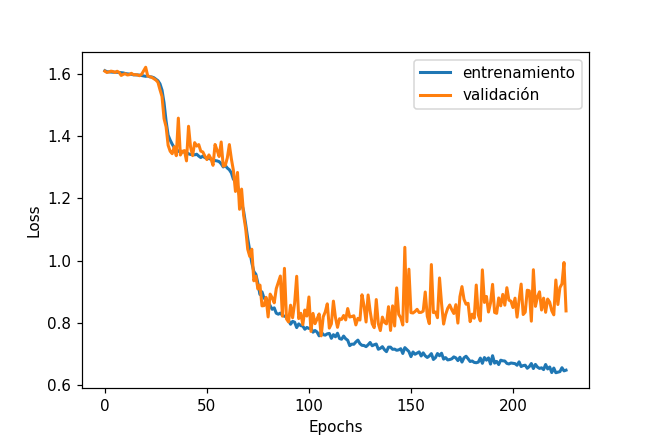

227


In [75]:
#plt.figure()
#plt.plot(range(len(TL)),TL,'r-',range(len(VL)),VL,'g-')
fig, ax = plt.subplots(figsize=(6, 4))
print(len(TL))
ax.plot(range(len(TL)), TL, lw=2, label='entrenamiento')
ax.plot(range(len(VL)), VL, lw=2, label='validación')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
#ax.set_ylim([0.2, 0.6])
plt.legend()
plt.show()

In [77]:
display(min(TL), min(VL), np.average(ACC))

0.6395440263951079

0.7579765103080056

56.42472066993966

#### Matriz de Confusion

- cargar mejor modelo
- un for que recorra elementos del dataset completo
    - tambien puede ser con el dataLoader pero SIN validacion
    - armar una lista con la cantidad de predichas
- preparar el dataset VVV
- pasarlo por modelo.forward(VVV['data'])
- softmax (?)
- guardar predicciones
- comparar con labels reales
- comparar 5 clases

In [64]:
besto = MLP()
PATH = '/home/amorales/models/best_LCC_model__Rot0_Alpha'+str(1)+'_sampleo'+str(2)+'.pt'
besto.load_state_dict(torch.load(PATH)['model_state_dict'])

<All keys matched successfully>

In [65]:
# MODIFICAR
#y_true = [best_of_best[i]['label'].item() for i in range(len(best_of_best))]
#y_true = [VVV[i]['label'].item() for i in valid_idx]

#print(y_true)
prediction_test = []
labels_test=[]
for data in test_loader:
    inputs, labels = data['data'],data['label']
    data,mask = inputs[:,:2],inputs[:,2].unsqueeze(-1)
    labels_test.append(labels.detach().numpy())
    outputs = besto.forward(data,mask,t=2)
    #logits = modelo.forward(sample_data)
    #print(outputs)
    prediction_test.append(outputs.detach().argmax(dim=1).numpy())
y_true = np.concatenate(labels_test)
#print(y_true)
y_pred = np.concatenate(prediction_test)
#print(y_pred)
print(y_pred.__len__()/5)
cm = confusion_matrix(y_true, y_pred)
display(cm)

print(classification_report(y_true, y_pred))

21.8


array([[ 0,  0, 19,  0,  4],
       [ 0,  0, 21,  0,  2],
       [ 0,  0, 18,  0,  0],
       [ 0,  0,  3,  3, 14],
       [ 0,  0,  0,  0, 25]])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        23
           2       0.30      1.00      0.46        18
           3       1.00      0.15      0.26        20
           4       0.56      1.00      0.71        25

    accuracy                           0.42       109
   macro avg       0.37      0.43      0.29       109
weighted avg       0.36      0.42      0.29       109



In [ ]:
#y_true = [VVV[i]['label'].item() for i in test_set]
prediction_test = []
for data in test_loader:
    inputs, labels = data['data'],data['label']
    data,mask = inputs[:,:,:4],inputs[:,:,4].unsqueeze(-1)
    #print(data.shape,mask.shape)
    outputs=modelo.forward(data,mask,t=2)
    #logits = modelo.forward(sample_data)
    prediction_test.append(torch.argmax(outputs, dim=1).detach().numpy())

y_pred = np.concatenate(prediction_test)

cm = confusion_matrix(y_true, y_pred)
display(cm)

print(classification_report(y_true, y_pred))

In [ ]:
print("state_dict del módelo entrenado:")
for param_tensor in modelo.state_dict():
    print(param_tensor, "\t", modelo.state_dict()[param_tensor].size())
    print(param_tensor, "\t", modelo.state_dict()[param_tensor])

print("\nstate_dict del módelo recuperado:")
for param_tensor in besto.state_dict():
    print(param_tensor, "\t", besto.state_dict()[param_tensor].size())
    print(param_tensor, "\t", besto.state_dict()[param_tensor])

- ver la matriz de confusion de la red sin entrenar

### Comparación entre distintos Modelos
Historial Matrices de Confusion [https://docs.google.com/spreadsheets/d/1j9kseGSx1WQvkb1C4nDL5J-lweuH3VyPsrAT50E1D6w/edit#gid=0]